In [81]:
import os 
import pandas as pd

ITERATIONS = 2
columns=["dataset", "mtl", 'gamma', "accuracy", "precision", "recall", "duration"]
stl_results_fcn = pd.DataFrame(columns=columns)
stl_results_res = pd.DataFrame(columns=columns)



for idx, dataset in enumerate(['Beef']):#, 'Beef', 'GunPoint']):#,'Beef']):#enumerate(os.listdir('./archives/ucr')):

    bac = 0; acc=0; precision=0; recall=0; duration=0

    for classifier in ['ae_iter','conv_iter']: 

        for gamma in [1]:

            stl_results_fcn_i = pd.DataFrame(columns=columns)
            stl_results_res_i = pd.DataFrame(columns=columns)

            for itr in range(ITERATIONS): 
                fcn_model = pd.read_csv(f'./results/ucr/{dataset}/experiment_4/fcn/fcn_mt_{classifier}_{gamma}_{itr}/{"fcn_ig_raw"}/df_best_model.csv')
                fcn_metrics = pd.read_csv(f'./results/ucr/{dataset}/experiment_4/fcn/fcn_mt_{classifier}_{gamma}_{itr}/{"fcn_ig_raw"}/task1_df_metrics.csv')
                #res_model = pd.read_csv(f'./results/ucr/{dataset}/experiment_3/resnet/resnet_mt_{classifier}_{gamma}_{itr}/{"resnet_ig_raw"}/df_best_model.csv')
                #res_metrics = pd.read_csv(f'./results/ucr/{dataset}/experiment_3/resnet/resnet_mt_{classifier}_{gamma}_{itr}/{"resnet_ig_raw"}/task1_df_metrics.csv')

                

                fcn_vals = [fcn_metrics["accuracy"].values[0], fcn_metrics["precision"].values[0],
                            fcn_metrics["recall"].values[0], fcn_metrics["duration"].values[0]] 
                #res_vals = [res_metrics["accuracy"].values[0], res_metrics["precision"].values[0],
                #            res_metrics["recall"].values[0], res_metrics["duration"].values[0]] 
                #Read STL results for FCN classifier
                if itr == 0:
                    stl_results_fcn_i.loc[idx] = [dataset,classifier,gamma] + fcn_vals
                    #stl_results_res_i.loc[idx] = [dataset,classifier,gamma] + res_vals
                else:
                    stl_results_fcn_i.loc[idx, columns[3:]] += fcn_vals
                    #stl_results_res_i.loc[idx, columns[3:]] += res_vals

            stl_results_fcn_i.loc[idx, columns[3:]] /= ITERATIONS
            #stl_results_res_i.loc[idx, columns[3:]] /= ITERATIONS

            stl_results_fcn = stl_results_fcn.append(stl_results_fcn_i)
            #stl_results_res = stl_results_res.append(stl_results_res_i)

#G:\Meine Ablage\master thesis\code\xai-tsc\results\ucr\Beef\experiment_4\fcn\fcn_mt_ae_iter_0.75_0\fcn_ig_raw\df_best_model.csv
#/results/ucr/Coffee/experiment_4/fcn/fcn_mt_ae_iter_0.75_0/fcn_ig_raw/df_best_model.csv'

#./results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_0/fcn_ig_raw/df_best_model.csv'
# results\ucr\Coffee/experiment_4/fcn\fcn_mt_test_0.75_0\fcn_ig_raw


C:\Users\boent\AppData\Local\Temp\ipykernel_80608\1702477061.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stl_results_fcn = stl_results_fcn.append(stl_results_fcn_i)
C:\Users\boent\AppData\Local\Temp\ipykernel_80608\1702477061.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stl_results_fcn = stl_results_fcn.append(stl_results_fcn_i)


In [82]:
stl_results_fcn

,dataset,mtl,gamma,accuracy,precision,recall,duration
0,Beef,ae_iter,1,0.600000,0.599268,0.600000,0.308486
0,Beef,conv_iter,1,0.616667,0.570299,0.616667,0.242832


In [83]:
stl_results_res

,dataset,mtl,gamma,accuracy,precision,recall,duration


### Calculate Custom Metrics for Attribution Method


In [96]:
import tensorflow_addons as tfa
from utils.explanations import integrated_gradients
from keras.utils import CustomObjectScope
import tensorflow.keras as keras
import tensorflow as tf
import os
from utils.explanations import minmax_norm
from utils.explanations import calculate_ig_attributions
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.utils import read_dataset
from sklearn.preprocessing import normalize
import numpy as np



# Load model to calculate custom metrics 
def load_model(root_dir, archive_name, dataset_name, classifier, data_source): 
    with CustomObjectScope({'InstanceNormalization':tfa.layers.InstanceNormalization()}):
        model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                                + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                                + f'best_model.hdf5'
        model =keras.models.load_model(model_path ,compile=False)
        return model
    

def norm(values): 
    if not type(values) == np.ndarray:
        return normalize(values.numpy().reshape(1,-1))[0]
    else: 
        return normalize(values.reshape(1,-1))[0]
    
#define shared trunk
network = 'fcn' 
    
#store custom metrics for model
models_train  = dict()
models_test   = dict()
# Loop over data

archive = 'ucr'
dataset_name = 'GunPoint'
data_p = 'G:/Meine Ablage/master thesis/code/xai-tsc'

itr=0
gamma = 1
for idx, dataset in enumerate(['Beef']):#, 'Beef', 'GunPoint']):#,'Beef']):
    print(dataset)
    ylen = 1
    #Just for now:

    data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]
    #assertion,each ts has same length
    ylen = len(data[0][0])

    for model in ['fcn_mt_ae_iter']: #'fcn_mt_linear']: #['fcn_mt_ae','fcn_mt_conv', 'fcn_mt_linear']: 'fcn_mt_ae_iter',
        model_type = model.split('_')[0] 
        print(model)
        try: 


            #Load initial values after STL training
            #cam_data_stl = read_dataset(data_p, archive, dataset, 'fcn_cam_raw', ylen)[dataset]
            print(model_type)
            ig_data_stl  = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/test799_TEST', delimiter=',')
            original_data = read_dataset(data_p, archive, dataset, f'{model_type}_ig_raw', ylen)[dataset]
            
            #Load required models
            #cam_link = f'./results/ucr/{dataset}/fcn/fcn_mt_ae_0.0/fcn_cam_raw/best_model.hdf5'
            #ucr\GunPoint\experiment_1\fcn\fcn_mt_ae_0\fcn_ig_raw
        
            ig_link  = f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/last_model.hdf5'
            #f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/
            #cam_model =keras.models.load_model(cam_link ,compile=False)
            ig_model = keras.models.load_model(ig_link ,compile=False)

            #Calculate new  attributions
            print("Calculate")
            ig_attributions = calculate_ig_attributions(data_p, archive, f"{model}_{gamma}_{itr}", dataset, 
                                                        f"{model_type}_ig_raw", task=1, experiment=4)
            # train and test data
            # 1,3 are the labels:  
            for t in [1,3]:#,3]:
                
                tc = t 
                #Pearson and mse [p,m]
                pm1 = 0; pm2 = 0; mm1 = 0; mm2 = 0
                #predict values for all timeseries 
                print("pred", t, data[t-1].shape)

                pred = ig_model.predict(data[t-1])
                #run loop
                for ts in range(len(data[t])):                
                    #small workaround
                    #structure of attributions 0 --> train 1 --> test set
                    pm1 += np.corrcoef(norm(pred[1][ts].flatten()),norm(ig_data_stl[ts]))[0,1]
                    pm2 += np.corrcoef(norm(pred[1][ts].flatten()),norm(ig_attributions[0 if t == 1 else 1][ts][2]))[0,1]
                    mm1 += mean_squared_error(norm(pred[1][ts].flatten()),norm(ig_data_stl[ts]))
                    mm2 += mean_squared_error(norm(pred[1][ts].flatten()),norm(ig_attributions[0 if t == 1 else 1][ts][2]))
                #Init for model 
                l = len(data[t])
                if t == 1: 
                    #f'{dataset}_{model.split("_")[-1]}'
                    models_train[f'{dataset}_{model.split("_")[-2]}'] = {"model" : model, "pm1":pm1/l,"pm2": pm2/l,"mm1":mm1/l, "mm2": mm2/l}
                else: 
                    models_test[f'{dataset}_{model.split("_")[-2]}'] =  {"model" : model , "pm1":pm1/l, "pm2": 
                                                                         pm2/l, "mm1":mm1/l,  "mm2": mm2/l}
                
        except Exception as e: 
            print(dataset,"error", e)
            pass


 #./results/ucr/GunPoint/experiment_1/resnet/resnet_mt_conv_0/resnet_ig_raw/last_model.hdf5
 
#G:/Meine Ablage\master thesis\code\xai-tsc\results\ucr\Coffee\experiment_3\fcn\fcn_mt_conv_cas_0.75_0\fcn_ig_raw\last_model.hdf5
#G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Coffee//experiment_3/fcn/fcn_mt_conv_cas_0.75/fcn_ig_raw/last_model.hdf5
#results\ucr\Beef\experiment_4\fcn\fcn_mt_test_0.75_0\fcn_ig_raw\last_model.hdf5
#results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_1/fcn_ig_raw/last_model.hdf5

Beef
fcn_mt_ae_iter
fcn
Calculate
1/1 [==============================] - 0s 96ms/step
pred 1 (30, 470)
1/1 [==============================] - 0s 426ms/step
pred 3 (30, 470)
1/1 [==============================] - 0s 100ms/step


In [95]:
import pandas as pd
pd.DataFrame(models_test).T

""


In [87]:
#ig_data_stl  = np.loadtxt('./test_TRAIN', delimiter=',')

In [91]:
from scipy.interpolate import interp1d
def prepare_visualize_attribution(ts,attribution):
    max_length = 2000    
    #prepare values
    minimum = np.min(attribution)
    cas = attribution - minimum
    cas = cas / max(cas)
    cas = cas * 100
    xv= np.linspace(0, len(ts) - 1, max_length, endpoint=True)
    f = interp1d(range(len(ts)),ts)
    yv = f(xv)
    f = interp1d(range(len(ts)),cas)
    cas = f(xv).astype(int)
    return xv,yv,cas




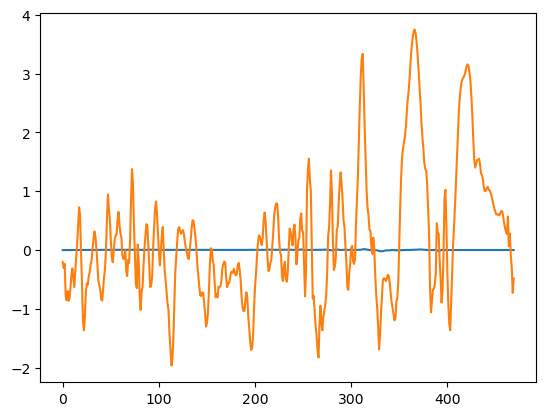

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt

ts = 4
plt.plot(ig_data_stl[ts])
#plt.plot(original_data[3][ts])
#plt.plot(ig_attributions[0 if t == 1 else 1][ts][2])

plt.plot(pred[1][ts].flatten())
plt.show()




In [28]:
data[2][ts]

array([-2.3965e-02, -2.3965e-02, -3.0769e-02, -3.2459e-02, -2.6175e-02,
       -1.7161e-02, -1.2004e-02,  2.1278e-02,  4.4897e-02,  6.1971e-02,
        9.6684e-02,  1.2641e-01,  1.5952e-01,  1.9059e-01,  2.2730e-01,
        2.5425e-01,  2.8286e-01,  3.1701e-01,  3.4613e-01,  3.7447e-01,
        4.0372e-01,  4.4424e-01,  4.6868e-01,  4.7575e-01,  4.9928e-01,
        5.1700e-01,  5.2745e-01,  5.4318e-01,  5.5445e-01,  5.5965e-01,
        5.7399e-01,  5.8391e-01,  5.8461e-01,  5.9748e-01,  6.1685e-01,
        6.4614e-01,  6.7956e-01,  6.9568e-01,  6.9277e-01,  6.9784e-01,
        7.1414e-01,  7.3113e-01,  7.6081e-01,  7.9002e-01,  8.1407e-01,
        8.4176e-01,  8.6915e-01,  8.9641e-01,  9.0820e-01,  9.0157e-01,
        8.8302e-01,  8.6612e-01,  8.4952e-01,  8.3414e-01,  8.1923e-01,
        7.9674e-01,  7.7260e-01,  7.4525e-01,  7.1176e-01,  6.7605e-01,
        6.4978e-01,  6.3167e-01,  6.3748e-01,  6.5416e-01,  6.6058e-01,
        6.6413e-01,  6.6140e-01,  6.5863e-01,  6.1819e-01,  5.63

In [29]:
pred[1][0]

array([[-1.86297868e-03],
       [-4.00978373e-03],
       [-3.57942702e-03],
       [ 8.36106250e-04],
       [-3.83114256e-03],
       [ 1.83657580e-03],
       [-7.22594094e-04],
       [-3.54525400e-04],
       [-2.37492262e-03],
       [-1.31578045e-03],
       [-1.18027697e-03],
       [ 5.95571473e-05],
       [ 1.12354220e-03],
       [ 1.74597534e-03],
       [ 1.41586526e-03],
       [ 4.02521575e-04],
       [ 2.08066055e-03],
       [ 2.31540739e-03],
       [ 2.22323020e-03],
       [ 2.17312924e-03],
       [ 1.35970465e-03],
       [-6.14196993e-04],
       [ 1.46298646e-03],
       [ 1.97361107e-03],
       [ 2.47991108e-03],
       [-7.61840958e-04],
       [-2.56687310e-03],
       [-1.02991331e-03],
       [ 1.31952181e-03],
       [ 5.54589787e-04],
       [ 7.91093335e-05],
       [ 1.97852240e-03],
       [ 4.86963708e-03],
       [ 4.36143391e-03],
       [ 2.93701631e-03],
       [ 3.40733840e-03],
       [ 2.36008433e-03],
       [ 2.33208085e-03],
       [ 3.5

In [30]:
xv,yv,av =prepare_visualize_attribution(data[2][ts],pred[1][ts])
plt.plot(pred[1][ts])
plt.scatter(xv,yv,c=av, cmap='jet', vmin=0,vmax=100,s=1, label='predicted')

ValueError: x and y arrays must be equal in length along interpolation axis.

240


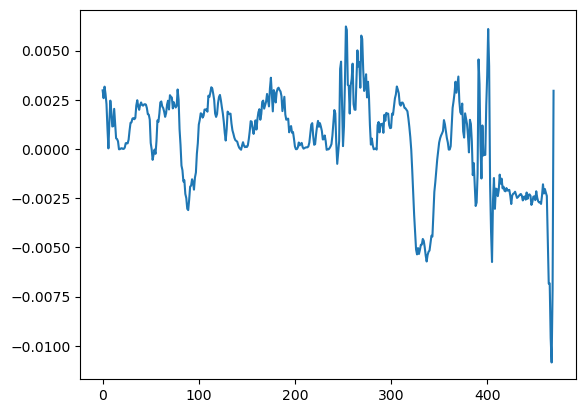

260


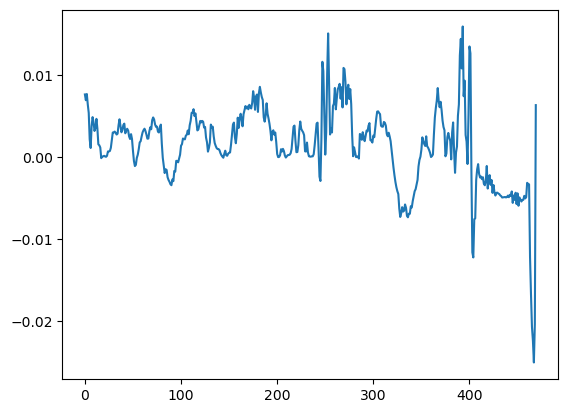

In [34]:
import numpy as np
p = "G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_3/fcn_ig_raw/test200_TRAIN"
g = np.loadtxt(p, delimiter=',')

#print(g)
for  i  in range(240,250,10):
    print(i)
    p = f"G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_3/fcn_ig_raw/test{i}_TRAIN"
    g = np.loadtxt(p, delimiter=',')
    plt.plot(g[0])

plt.show()

for  i  in range(260,270,10):
    print(i)
    p = f"G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_3/fcn_ig_raw/test{i}_TRAIN"
    g = np.loadtxt(p, delimiter=',')
    plt.plot(g[0])

plt.show()